In [1]:
# include tools
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data info and path
DATA_DIR = Path('data')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

<AxesSubplot: title={'center': 'Number of Buildings with Each Damage Grade'}>

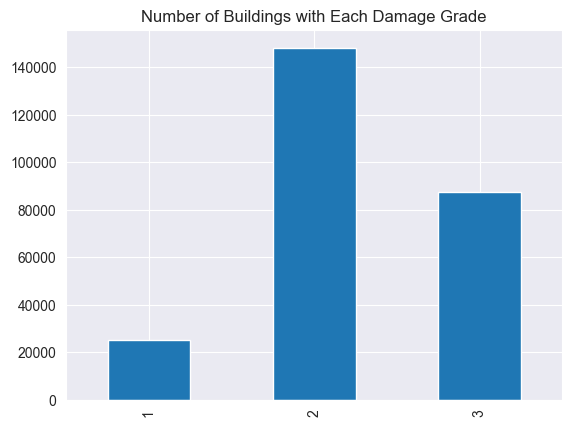

In [3]:
# explore the data
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [4]:
selected_features = ['foundation_type',
                     'area_percentage',
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

#train_values_subset = train_values[selected_features]
train_values_subset = train_values

# a quick look at the relationships between our numeric features and labels
# sns.pairplot(train_values_subset.join(train_labels), hue='damage_grade')

In [5]:
# build the model

# for preprocessing the data
train_values_subset = pd.get_dummies(train_values_subset)

from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [6]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [7]:
# hyperparameter search
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)
gs.fit(train_values_subset, train_labels.values.ravel())
gs.best_params_

KeyboardInterrupt: 

In [ ]:
# F1 micro score
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

In [ ]:
# predict and submit the results
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

# select the subset of features we used to train the model and create dummy variables.
test_values_subset = test_values
test_values_subset = pd.get_dummies(test_values_subset)

# make prediction
predictions = gs.predict(test_values_subset)

# save submission
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.head()

In [ ]:
my_submission.to_csv('submission.csv')
# check the head of the saved file
!type submission.csv